# Putting the p-value in Context

Neuroscience researchers typically report p-values to express the strength of statistical evidence; but p-values are not sufficient on their own to understand the meaning and value of a scientific inference. In this unit, learners will learn how to interpret the p-value, how to express the size of an effect and uncertainty about a result, and how to interpret results at both the individual and population levels.

<div class="alert alert-block alert-danger">
<b>Alert:</b> If you're running this on <b>Google Colab</b>, then uncomment and run the next two cells.
</div>

In [1]:
# !git clone https://github.com/Mark-Kramer/METER-Units.git

In [2]:
# import sys
# sys.path.insert(0,'/content/METER-Units')

## 1 - Here’s some data, give me the p’s!

In [3]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pvalue_functions import *

<div class="alert alert-block alert-info">

*Introduction*:
- Your lab collects an EEG biomarker of memory ([sleep spindles](https://en.wikipedia.org/wiki/Sleep_spindle)) from N=30 human subjects.

- To do so, your lab measures the [power](https://mark-kramer.github.io/Case-Studies-Python/03.html) in the spindle band (9-15 Hz) twice per minute. Your lab has a [reliable method](https://mark-kramer.github.io/Case-Studies-Python/04.html#multitaper) to detect spindle activity; this detector is known to be accuactivity outside of treatment. We expect it to still work during treatment, but we also expect more variability in the spindle power estimates (hence more variability in the detections) during treatment.
    
- Your lab measures spindle activity during three conditions:
    
    - **Baseline**: Data collection lasts 7 hours while the subject sleeps on an evening before the intervention. This results in 840 samples of spindle activity for each subject.
    
    - **During Treatment**: Data collection during a 15 minute intervention during sleep, resulting in 30 samples of spindle activity for each subject.
    
    - **Post-treatment**: Data collection after intervention lasts 7 hours, while the subject sleeps, resulting in 840 samples of spindle activity for each subject.
  
-  Your PI says: *I want to know if there’s an effect of treatment in each human. **Give me the p’s!***

</div>

<div class="alert alert-block alert-success">

**Q:** What does the PI mean by *"Give me the p's"*?

**A:** (Short answer - word cloud ...)
</div>

<div class="alert alert-block alert-success">

**Q:** Exercise that asks about the appropriateness of p-values for different types of research questions.

**A:** (Goal is to build intition for what a p-value means.)

Yes/No question matching (Uri to add).

</div>

<div class="alert alert-block alert-success">

**Q:** Have you ever computed a p-value (in software)?

**A:** (Survey)
</div>

## 2- Let’s do it: Define & compute p-values.


Let's start by considering answers to these two questions:

- What does a p-value test?

  Sometimes statisticians think backwards. We'd like to know how the spindle activity changes relative to baseline. To test this, we'll start by assuming the opposite: we'll hypothesize that the spindle activity does not change. This is called the **null hypothesis**. The p-value indicates how much evidence we have to reject the null hypothesis given the data we observe. It's like a measure of surprise. If we're surprised by the observed data, then we'll reject the null hypothesis, and conclude we have evidence that the spindle activity changes relative to baseline.

  Alternatively, if we're not surprised by the observed data, then we'll conclude that we lack sufficient evidence to reject the null hypothesis. There's an important subtely here that statisicians like to point out - when we're testing this weay, we never accept the null hypothesis. Instead, the best we can do is talk like a statistican and say things like "we fail to reject the null hypothesis".

- What does p<0.05 mean?

    The probability of observing the data, or something more extreme, under the null hypothesis is less than 5%. This is typically considered sufficient evidence to reject the null hypothesis in favor of the alternative hypothesis (which posits that there is an effect or a difference). In other words, a p-value less than 0.05 suggests that the observed data is unlikely to have occurred by random chance alone, assuming the null hypothesis is true, leading researchers to reject the null hypothesis.


Let's now return to the human data. First, let's consider the null hypothesis the PI wants to test.

<div class="alert alert-block alert-success">

**Q:** The PI says *“I expect that during treatment the spindle activity exceeds the baseline spindle activity.”* What is the null hypothesis?

**A:** (Multiple Choice)

Correct answer: No difference in average spindle activity during treatment compared to baseline.

</div>

Now, let's load the data and compute the p-values.

In [4]:
baseline, during_treatment, post_treatment = load_data()

Let's start by investigating the structure of the data.

In [5]:
print(baseline.shape)
print(during_treatment.shape)
print(post_treatment.shape)

(840, 20)
(30, 20)
(840, 20)


All three variables consist of observations from 20 subjects (the number of columns). We collect 30 samples during treatment and 840 samples at baseline (i.e., before treatment) and after treatment; this is the the number of rows for each variable.

You might think of these variables as rectangles (or matrices), where each row indicates a sample of spindle activity, and each column indicates a subject:

![title](IMG_Pvalue/simple_boxes_during_and_post.jpg)

<div class="alert alert-block alert-success">

**Q:** Look at the representations of the data above. What differs about the data during treatment, compared to baseline and post-treatment?

**A:** (Multiple Choice)

Correct answer: There are fewer samples during treatment.

</div>

To get a sense for the the data, let's plot the spindle activitys during `baseline` for one subject:

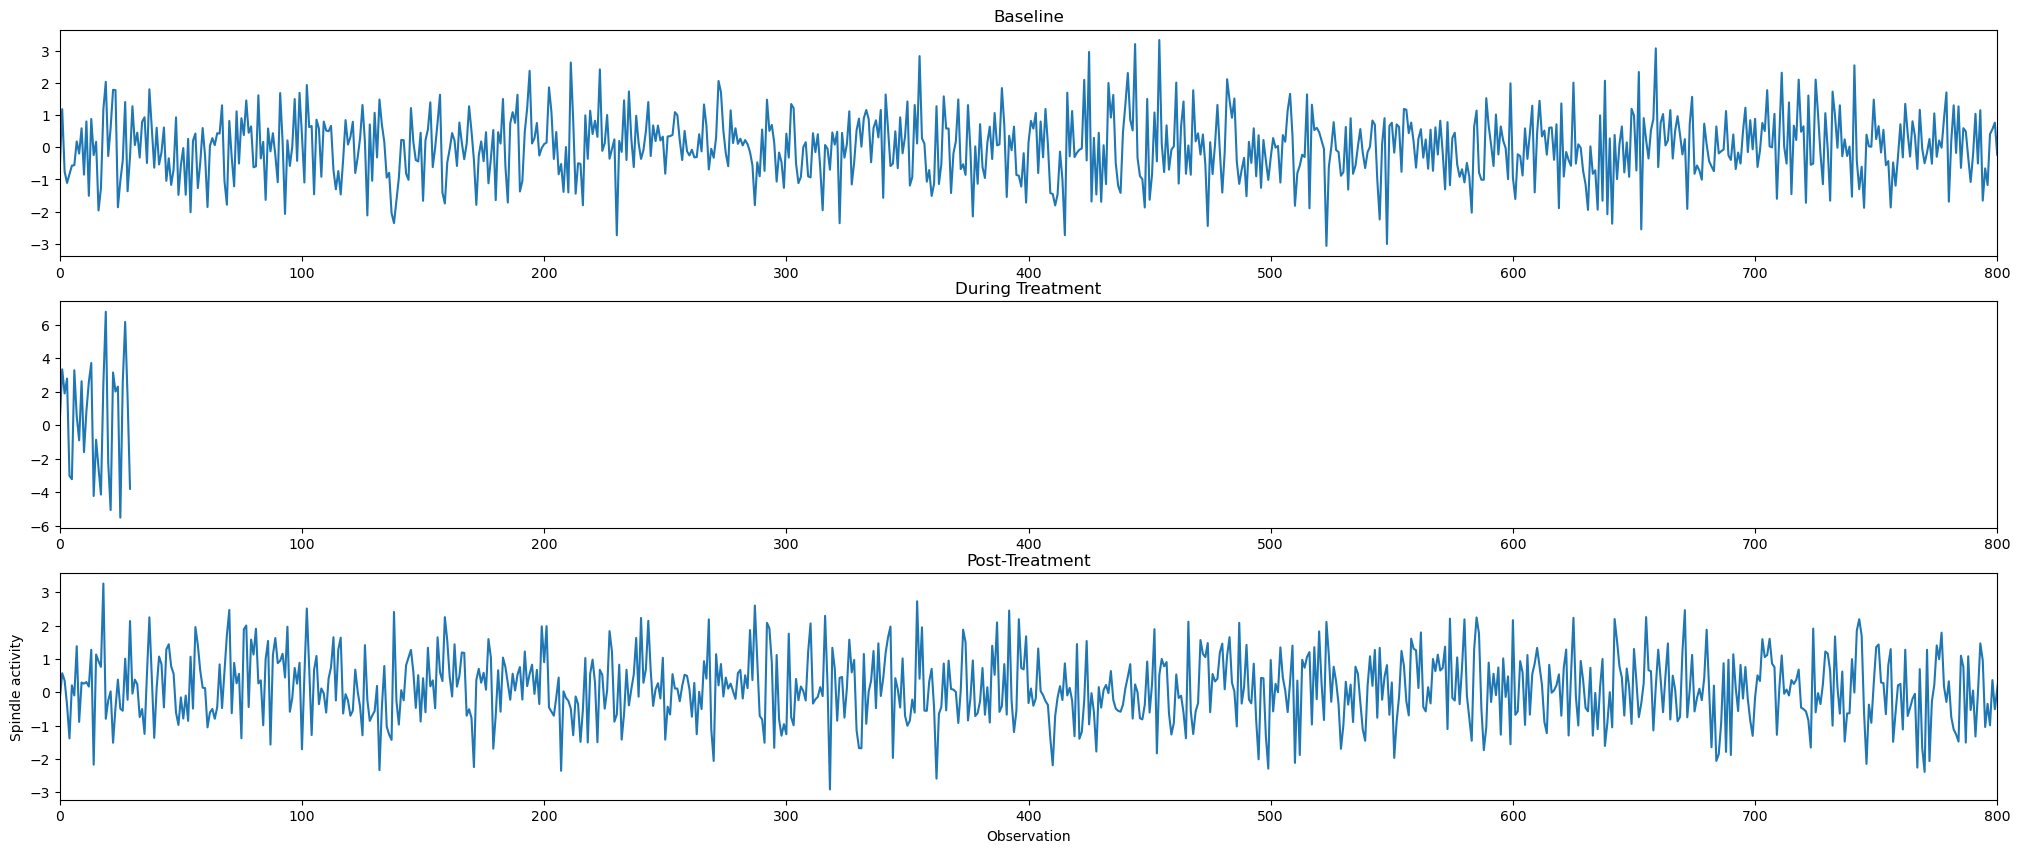

In [6]:
f, ax = plt.subplots(3,1, figsize=(25,10))
ax[0].plot(baseline[:,0]); ax[0].set_xlim([0,800]); ax[0].set_title('Baseline');
ax[1].plot(during_treatment[:,0]); ax[1].set_xlim([0,800]); ax[1].set_title('During Treatment');
ax[2].plot(post_treatment[:,0]); ax[2].set_xlim([0,800]); ax[2].set_title('Post-Treatment');
plt.xlabel('Observation'); plt.ylabel('Spindle activity');

<div class="alert alert-block alert-success">

**Q:** What values do you observe for the spindle activity?

**A:** The values tend to fluctuate around 0, and can be both positive and negative. Here, the spindle activity has been z-scored during each recording interval relative to baseline. So, the values we observe indicate changes relative to the mean baseline spindle activity; positive (negative) values indicate increases (decreases) in spindle activity relative to the baseline activity.
</div>

<div class="alert alert-block alert-success">

**Q:** What differences or similarites do you notice in spindle activity in baseline, during treatment, and post-treatment?

**A:** Similarities:
- All fluctuate around 0.

Differences:
- During treatment there are fewer samples.
- During treatment, the fluctuations are bigger (the data is "noiser").
</div>

Let's now compute the p-values `during treatment`. That's the item of primary scientific interest in our study.

To do so, we'll assume the null hypothesis of no difference in spindle rate during treatment.

Because we've subtracted the baseline spindle rate, the null hypothesis becomes:

**Null hypothesis**: Mean spindle rate during treatment = 0

In [7]:
p_value_during = create_dropdown_compute_pvalues(during_treatment)

Dropdown(description='Options:', options=('I want to write all the code myself.', 'Show me the code and I will…

Output()

In [8]:
# The above doesn't return values yet ... so run this:
result         = stats.ttest_1samp(during_treatment,popmean=0)
p_value_during = result.pvalue

Let's investigate the shape of these results:

In [9]:
print(p_value_during.shape)

(20,)


<div class="alert alert-block alert-success">

**Q:** Do these shapes make sense?

**A:** Yes, there's one p-value per subject, and we have 20 subjects.

</div>

Let's print the p-values for each subject:

In [10]:
for k in np.arange(0,20):
    print('Subject ', k, ', p=', np.array2string(p_value_during[k], precision=5))

Subject  0 , p= 0.51764
Subject  1 , p= 0.88867
Subject  2 , p= 0.63339
Subject  3 , p= 0.22295
Subject  4 , p= 0.00638
Subject  5 , p= 0.30963
Subject  6 , p= 0.01242
Subject  7 , p= 0.99443
Subject  8 , p= 0.08998
Subject  9 , p= 0.26046
Subject  10 , p= 0.07091
Subject  11 , p= 0.13959
Subject  12 , p= 0.01699
Subject  13 , p= 0.11679
Subject  14 , p= 0.19091
Subject  15 , p= 0.734
Subject  16 , p= 0.30088
Subject  17 , p= 0.46395
Subject  18 , p= 0.04994
Subject  19 , p= 0.29267


Let's also plot the p-values:

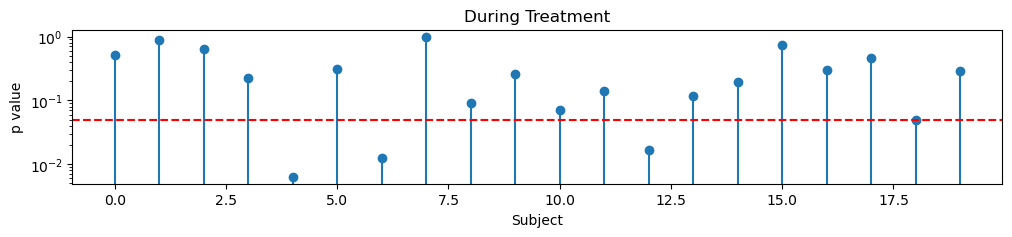

In [11]:
# Plot the p-values during treatment
plt.figure(figsize=(12, 2))
plt.stem(p_value_during);
plt.axhline(y=0.05, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('During Treatment'); plt.yscale('log')

<div class="alert alert-block alert-success">

**Q:** Interpert the print-out and plots of p-values. What do you see?

**A:** The p-values tend to exceed 0.05, although a few subjects have p<0.05.

</div>

**Now, do we have evidence to reject the null hypothesis?**

Maybe ... if we had performed one statistical test, then we typically reject the null hypothesis if

`p < 0.05`

But here we compute 20 test (one for each subject). When we perform multiple tests, it's important we consider the impact of *[multiple comparisons](LINK Reproducible exploratory analysis)*.

To do so here we'll apply a *[Bonferroni correction](LINK Reproducible exploratory analysis)*. That means we'll compare the p-values we compute to a stricter threshold

`p < 0.05 / 20` or `p < 0.0025`

Let's plot the p-values versus this new threhsold.

Significant p-values during treatment =  0


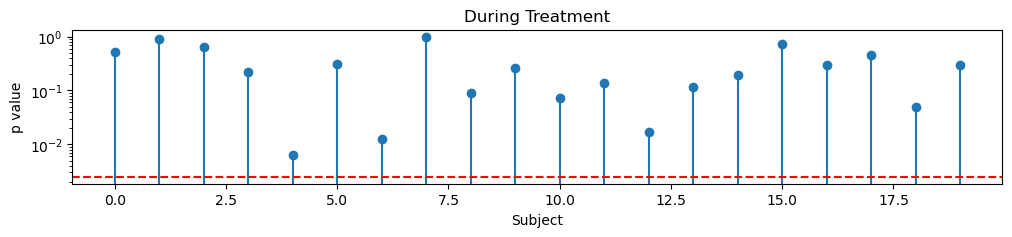

In [12]:
# Plot the p-values during treatment
plt.figure(figsize=(12, 2))
plt.stem(p_value_during);
plt.axhline(y=0.05/20, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('During Treatment'); plt.yscale('log')

print('Significant p-values during treatment = ',np.sum(p_value_during < 0.05/20))

<div class="alert alert-block alert-success">

**Q:** After the Bonferroni correction, can we reject the null hypothesis for any subject?

**A:** No. None of the p-values are less than 0.05/20.

</div>

<div class="alert alert-block alert-success">

**Q:** The PI requested *“Give me the p’s!”*. Do you have evidence to reject the null hypothesis during treatment?

**A:** No! Because the p-values are large, we find no evidence to reject the null hypothesis for any subject.

</div>

<div class="alert alert-block alert-success">

**Q:** We do not find any p-values that pass our significance threshold during treatment. Does this mean that the spindle activity during treatment does not change relative to baseline?

**A:** No! We never accept the null hypothesis. Remember we have to talk like a statistician. The most we can say is:
    
"We fail to reject the null hypothesis that the spindle activity during treatment differs from baseline."

</div>

<div class="alert alert-block alert-danger">
<b>Summary:</b> We've computed p-values testing the null hypothesis:
    
- that the spindle activity during treatment = 0,

We've done this for each subject. Our intial results suggest provide no evidence that we can reject the null hypothesis during treatment.
</p>
</div>

<div class="alert alert-block alert-success">

**Q:** Before finishing this Mini, let's review:
    
1. What is the scientific question we're seeking to answer? (Multiple Choice)
2. What statistical approach did we use to answer that question? (Multiple Choice)

**A:** 
1. Does the spindle activity during treatment differ from the baseline spindle activity?
    
2. To answer this question, we assumed a null hypothesis of no difference in spindle activity during treatment compared to 0. We then tested this null hypothsis for each subject, and computed a p-value. We rejected the null hypothesis if the p-value was small enough. Notice that, in doing so, we compute a p-value to provide a yes/no answer to the question: do we have evidence that the spindle activity during treatment differs from 0?
    
</div>

## 3- Maybe there's something else we can publish?

The results in Mini 2 are discouraging; we find no evidence of a change in spindle activity from baseline during treatment.

That's discouraging, so the PI asks we continue to explore the results.

Specifically, we're tasked with investigating the change in spindle activity `post-treatment`.

We do *not* expect a change in spindle activity post-treatment, compared to baseline.

<div class="alert alert-block alert-success">

**Q:** Given this expectation, how can we test it?

**A:** Let's make the null hypothesis:

**Null hypothesis**: Mean spindle activity post-treatment = 0
    
Remeber, we've subtracted the baseline spindle activity from the post-treatment value. So, no change in spindle activity post-treatment would result in values the fluctuate around 0.

</div>

<div class="alert alert-block alert-danger">
<b>Alert:</b> We're embarking on a dangerous analysis path, beginning an exploratory analysis after our initial hypothesis failed. Exploratory analysis is fine, we just need to be careful about our approach. For more details, check out [LINK: Reproducible exploratory analysis].
</p>
</div>

Now, let's repeat the analysis in Mini 2, but now examining the `post-treatment` spindle activity.

In [13]:
result = stats.ttest_1samp(post_treatment,popmean=0,alternative='greater')
p_value_post = result.pvalue

Let's print and plot the p-values for each subject:

In [14]:
for k in np.arange(0,20):
    print('Subject ', k, ', p=', np.array2string(p_value_post[k], precision=5))

Subject  0 , p= 3.5484e-05
Subject  1 , p= 3.42002e-07
Subject  2 , p= 0.0118
Subject  3 , p= 3.79151e-05
Subject  4 , p= 2.14138e-05
Subject  5 , p= 0.08528
Subject  6 , p= 0.00785
Subject  7 , p= 0.00314
Subject  8 , p= 0.00456
Subject  9 , p= 0.11923
Subject  10 , p= 0.01344
Subject  11 , p= 5.46145e-05
Subject  12 , p= 5.33086e-05
Subject  13 , p= 0.20811
Subject  14 , p= 9.74037e-07
Subject  15 , p= 0.34272
Subject  16 , p= 0.0003
Subject  17 , p= 0.01626
Subject  18 , p= 0.00096
Subject  19 , p= 0.00518


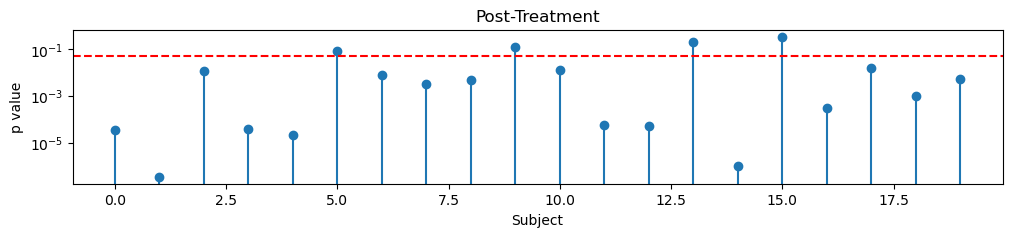

In [15]:
# Plot the p-values post-treatment
plt.figure(figsize=(12, 2))
plt.stem(p_value_post);
plt.axhline(y=0.05, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('Post-Treatment'); plt.yscale('log')

Let's also correct for multiple compariosns using a Bonferroni correction.

Significant p-values post-treatment =  9


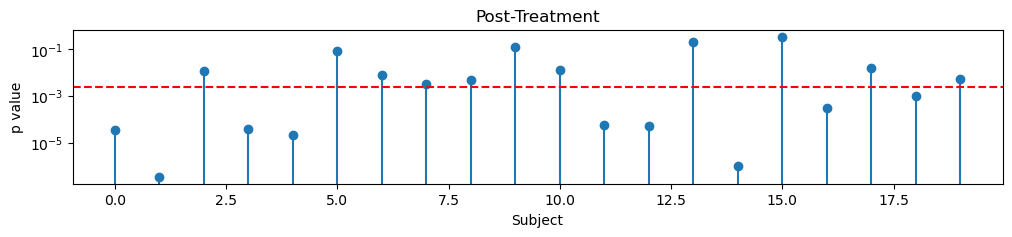

In [16]:
plt.figure(figsize=(12, 2))
plt.stem(p_value_post);
plt.axhline(y=0.05/20, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('Post-Treatment'); plt.yscale('log')
print('Significant p-values post-treatment = ',np.sum(p_value_post < 0.05/20))

<div class="alert alert-block alert-success">

**Q:** Compare these two sets of p-values, calculated during treatment (Mini 2) and post-treatment. What does it mean?

**A:** Look at how small the p-values are post-treatment!

Nine of the p-values post-treatment are less than 0.05/20, the Bonferroni corrected p-value threshold.

Alternatively, during treatment, the p-values are much bigger, and we find no p-values less than  0.05/20.

We find many more significant p-values post-treatment (9 out of 20, after Bonferroni correction).
</div>

Our results **seem** to point towards a new conclusion: 

- In Mini 2, we found no evidence of a change in spindle activity `during treatment`.
- In this Mini, we find many very small p-values (less than 0.05/20) `post-treatment`, and evidence of a lower spindle activity post-treatment in 9/20 subjects.

The PI is very excited with our progress, as these results upend the literature.

The PI drafts the title for a high-impact paper:

#### *“Post-Treatment Paradox: Clear Human Responses, Despite Absence of Treatment Effect"*

**But are we sure?**

<div class="alert alert-block alert-success">

**Q:** Review the characteristics of the during and post-treatment data (Mini 1). How might these characteristics impact the p-values?

**A:** This is a very important question ... and we're not going to answer it yet.

But here's a hint: notice that we collect many more samples post-treatment, compared to during treatment. I wonder how this might impact our p-value comparisons ... 

</div>

<div class="alert alert-block alert-danger">
<b>Alert: Wait, I'm not so sure ... </b>

</p>

- Why is the word *seem* in bold?

- Why did you ask me to review the characteristics of the data, and think about how this might impact the data?
</div>

<div class="alert alert-block alert-info">

*Moment of tension*:

- Hook the learner - "something isn't right and I want to know why."

</div>

<div class="alert alert-block alert-success">

**Q:** EXTENSION EXERCISE: How would you test the null hypothesis of spindle activity = 0 during the `baseline` condition?

</div>

<div class="alert alert-block alert-success">

**Q:** Before finishing this Mini, let's review:
    
1. What is the scientific question we originally sought to answer (Mini 2)? (Multiple Choice)
2. What is the scientific question we answered in this Mini? (Multiple Choice)
3. What statistical approach did we use to answer this scientific question? (Multiple Choice)

**A:** 
1. Does the spindle activity **during treatment** differ from the baseline spindle activity?

2. Does the spindle activity **post-treatment** differ from the baseline spindle activity?
    
2. To answer the scientific question in this Mini, we assumed a null hypothesis of no difference in spindle activity post-treatment compared to 0. We then tested this null hypothsis for each subject, and computed a p-value. We rejected the null hypothesis if the p-value was small enough. Notice that, in doing so, we compute a p-value to provide a yes/no answer to the question: do we have evidence that the spindle activity during post-treatment differs from 0?
    
</div>

## 4- Not so fast: visualize, always.

We may have found an interesting result: a lower spindle activity post-treatment, but no effect during treatment.

To do so, we analyzed and compared p-values, testing specific null hypotheses.

We've hinted above that something isn't right ... let's now dive in and identify where we went wrong.

<div class="alert alert-block alert-success">

**Q:** Let's remember - what was the original scientific question we wanted to test?

**A:** Does the spindle activity **during treatment** differ from the baseline spindle activity?
    
**Q:** How did we test this original scientific question?
    
**A:** We computed p-values to test the null hypothesis of no difference in spindle rate during treatment from 0.
  
</div>

Our initial hypothesis "failed" ... the p-values were too big.

So, we investigated the spindle activity post-treatment.

We applied the same strategy of computing p-values to test the null hypothesis that the spindle activity is 0.

**We have focused (almost exclusively) on p-values.**

Let's again plot the p-values during and post-treatment:

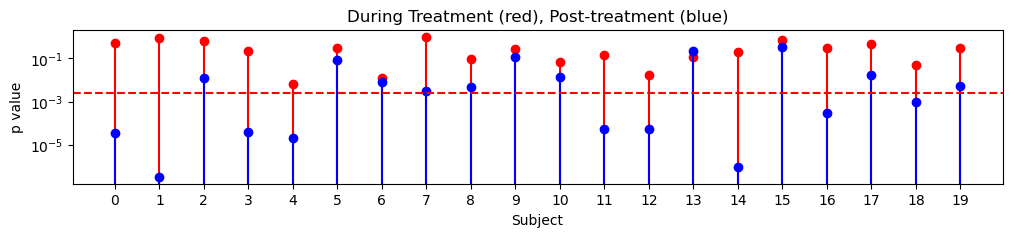

In [17]:
plt.figure(figsize=(12, 2))
l1 = plt.stem(p_value_during, 'or')
l2 = plt.stem(p_value_post, 'ob')
plt.yscale('log')
plt.axhline(y=0.05/20, color='r', linestyle='--')
plt.xticks(np.arange(0,20));
plt.xlabel('Subject'); plt.ylabel('p value');
plt.title('During Treatment (red), Post-treatment (blue)');

<div class="alert alert-block alert-success">

**Q:** For each subject, compare the p-values during treatment (red) versus post-treatment (blue). What do you observe?

**A:** We oberve a post-treatment effect in many subjects (the p-value is small), but not during treatment (the p-value is big).

</div>

So far, we've used the spindle measurements to compute p-values.

**But, we've almost completely ignored the spindle measurements themselves!**

Now, let's return to the spindle measurements and look at those values directly.

<div class="alert alert-block alert-success">

**Q:** Given our analysis of the p-values, how do you expect the spindle measurements behave during treatment and post-treatment?

**A:** 
- Because we do not find significnat p-values during treatment, I expect these values to appear near 0.
- Because we do find significnt p-values post-treatment, I expect these values to differ from 0.

</div>

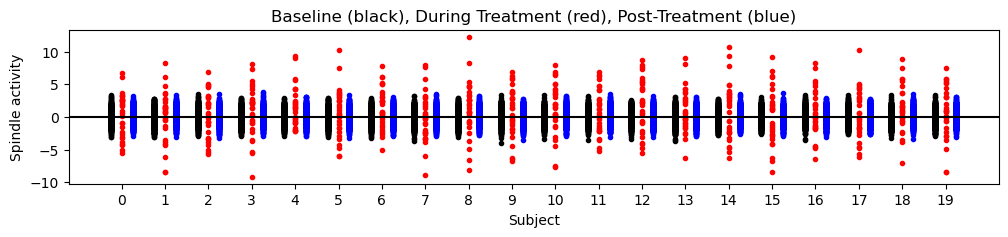

In [18]:
plt.figure(figsize=(12, 2))
for k in np.arange(0,20):
    plt.plot(np.tile(k,(840,1))-0.25, baseline[:,k], '.', color='k')
for k in np.arange(0,20):
    plt.plot(np.tile(k,(30,1)), during_treatment[:,k], '.', color='r')
for k in np.arange(0,20):
    plt.plot(np.tile(k,(840,1))+0.25, post_treatment[:,k], '.', color='b')
plt.axhline(y=0, color='k')
plt.xlabel('Subject'); plt.ylabel('Spindle activity'); plt.title('Baseline (black), During Treatment (red), Post-Treatment (blue)'); #plt.ylim([0,1]);
plt.xticks(np.arange(0,20));

<div class="alert alert-block alert-success">

**Q:** Looking at the plots of spindle measurements, what do you observe? More specifically:
1. Do you observe an effect during treatment?
2. Do you obesrve an effect post-treatment?
3. Are these plots consistent with you p-value results?

**A:** 
1. Yes, sort of ... the spindle measurements during treatment appear larger than post-treatment. How can that be if the p-values are big?
2. Not really ... because we find significant p-values post-treatment, I expect these values to differ from 0 and from the distribution of baseline values. But I don't see that here ...
3. Not really ... we concluded that there's an effect post-treamtnet, but not during treatment. However, these plots of spindle measurements aren't consistent with our conclusions.

</div>

It's nice to visualize all of the data, but doing so can also be overwhelming.

Let's summarize the spindle measurements in for each subject by ploting the [mean and the standard error of the mean](https://mark-kramer.github.io/Case-Studies-Python/02.html#cis-m1).

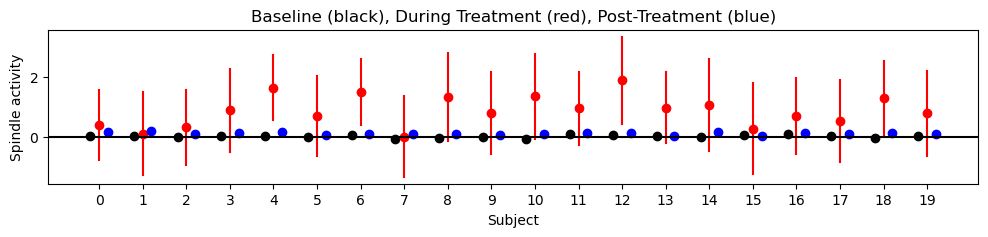

In [19]:
# Plot the spiking from an example neuron.
plt.figure(figsize=(12, 2))
for k in np.arange(0,20):
    mn = np.mean(baseline[:,k]);
    sd = np.std( baseline[:,k]);
    K  = np.shape(baseline)[0];
    plt.plot(k-0.2, mn, 'o', color='k')
    plt.plot([k-0.2,k-0.2], [mn-2*sd/np.sqrt(K), mn+2*sd/np.sqrt(K)], color='k')
for k in np.arange(0,20):
    mn = np.mean(during_treatment[:,k]);
    sd = np.std( during_treatment[:,k]);
    K  = np.shape(during_treatment)[0];
    plt.plot(k, mn, 'o', color='r')
    plt.plot([k,k], [mn-2*sd/np.sqrt(K), mn+2*sd/np.sqrt(K)], color='r')
for k in np.arange(0,20):
    mn = np.mean(post_treatment[:,k]);
    sd = np.std( post_treatment[:,k]);
    K  = np.shape(post_treatment)[0];
    plt.plot(k+0.2, mn, 'o', color='b')
    plt.plot([k+0.2,k+0.2], [mn-2*sd/np.sqrt(K), mn+2*sd/np.sqrt(K)], color='b')
plt.axhline(y=0, color='k')
plt.xlabel('Subject'); plt.ylabel('Spindle activity'); plt.title('Baseline (black), During Treatment (red), Post-Treatment (blue)');
plt.xticks(np.arange(0,20));

<div class="alert alert-block alert-success">

**Q:** Looking at the summary plots of spindle measurement means and standard error of the means for each subject, what do you observe? More specifically:
1. Do you observe an effect during treatment?
2. Do you obesrve an effect post-treatment?
3. Are these plots consistent with you p-value results?

**A:** 
1. Yes ... the spindle measurements during treatment appear larger than post-treatment. How can that be if the p-values are big during treatement?
2. Not really ... because we find significnt p-values post-treatment, I expect these values to differ from 0. But I don't see that here, the black and blue dots appear to overlap near 0 ...
3. Not really ... we concluded that there's an effect post-treatment, but not during treatment. However, these plots of spindle measurements aren't consistent with our conclusions.

</div>

Let's summarize what we've found so far:

| State | p-values | spindle activity |
|----------|----------|----------|
| During treatment   | p>0.05/20 (not significant) | mean spindle activity > 0   |
| Post-treatment    | p<<0.05/20  (signficiant)   | mean spindle activity $\approx$ 0.   |

Something's not adding up here ...

Looking at the spindle activity plots, we observe:

- the mean spindle activity during treatment often exceeds the mean spindle activity at baseline.

**That's the oppostive conclusion we made from the p-values!**

Hmm ... we better think carefully about the paper title ...

<div class="alert alert-block alert-danger">
<b>Alert:</b> We're made multiple statistial errors:

- Compared p-values 

- Exploratory analysis
    
</p>
</div>

<div class="alert alert-block alert-success">

**Q:** Why do the spindle activities during treatment exceed the baseline spindle activity, but p>0.05? And, why are the post-treatment spindle activities so near the baseline spindle activity, but p<<0.05?
    
**A:** The p-value measures the **strength of evidence** against the null hypothesis.
</div>

Two things impact the strength of evidence:
- the effect size (i.e., the values of the spindle activity).
- the number of observations

<div class="alert alert-block alert-success">

**Q:** How do the number of observations differ during treatment versus post-treatment? How might this impact the results?
    
**A:**
- We have many more observations post-treatment. Therefore, we can accumulate enough evidence to detect a weak effect post-treatment.
- We have few observations during treatment. Therefore, even though the effect is strong, we don't have enough evidence to declare an effect during treatment.
</div>

<div class="alert alert-block alert-danger">
    
**Conclusion / Summary / Morale:**

We began with the scientific statement:

*“I expect that during treatment the spindle activity exceeds the baseline spindle activity.”*

Our initial approach focused on computing and comparing p-values. That's a bad idea. We're not as interested in comparing the evidence we have for each null-hypothesis (the p-value); that depends on both the effect size and the number of observations.

Instead, we're more interested in comparing the spindle activity between condidtions. In other words, we're intested in the effect size, not the p-value.

This suggests a different analysis path forward for an improved approach. We can answer the same scienfitic question by comparing the spindle activitys beteween conditions, not the p-values. We've started to see this in the plots of spindle activity at baseline, during treatment, and post-treatment. For more analysis (e.g., different statistical test and effect size) continue on to other Minis.


## 5- A different test … a different result.


Originally (in Mini 2), we considered the null hypothesis:

- No difference in mean spindle activity during treatment **from 0**.

Let's now consider **a different null hypothesis**:

- No difference in mean spindle activity during treatment **versus baseline**.

To test this null hypothesis, we'll apply a different test:

- a subject specific two-sample t-test.

In [20]:
result = stats.ttest_ind(baseline, during_treatment, alternative='less')
p_value_baseline_vs_during = result.pvalue
for k in np.arange(0,20):
    print('Subject ', k, ', p=', np.array2string(p_value_baseline_vs_during[k], precision=4))

Subject  0 , p= 0.0364
Subject  1 , p= 0.3733
Subject  2 , p= 0.0704
Subject  3 , p= 7.712e-05
Subject  4 , p= 1.7514e-15
Subject  5 , p= 0.0008
Subject  6 , p= 1.0667e-12
Subject  7 , p= 0.3702
Subject  8 , p= 2.5241e-09
Subject  9 , p= 0.0001
Subject  10 , p= 1.6325e-10
Subject  11 , p= 2.7851e-05
Subject  12 , p= 3.2021e-16
Subject  13 , p= 1.5163e-05
Subject  14 , p= 4.2159e-06
Subject  15 , p= 0.1733
Subject  16 , p= 0.0024
Subject  17 , p= 0.0152
Subject  18 , p= 7.0189e-10
Subject  19 , p= 0.0004


Significant p-values during treatment =  14


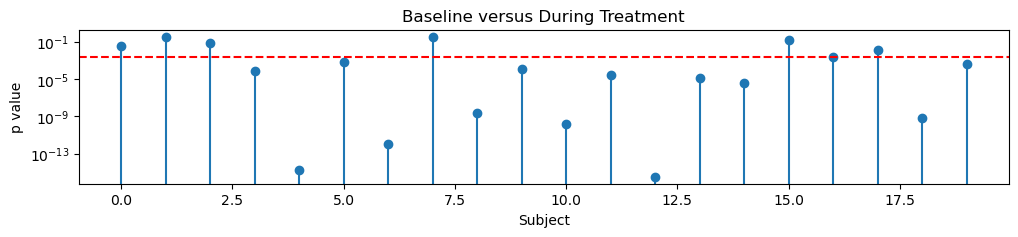

In [21]:
plt.figure(figsize=(12, 2))
plt.stem(p_value_baseline_vs_during);
plt.axhline(y=0.05/20, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('Baseline versus During Treatment'); plt.yscale('log')
print('Significant p-values during treatment = ',np.sum(p_value_baseline_vs_during < 0.05/20))

<div class="alert alert-block alert-success">

**Q:** Interpret these p-value results in terms of the null hypothesis.

**A:** We conclude that, in most cases, we reject the null hypothesis of no difference in spindle activity between baseline versus during treatment. We conclude that the spindle activity is higher during treatment compared to baseline in most subjects (14/20).

</div>

<div class="alert alert-block alert-success">

**Q:** Compare the results of these tests for each human to the results in Mini 2.

**A:** In Mini 2, we computed p-values during treatment versus 0. Now, we compute p-values during treatment versus baseline. These are different tests. The latter tests more directly our scientific question.

</div>

## 6- So, what went wrong?

What is the scientifc question we're actually trying to answer?

(PENDING): effect-size

(REVIEW): Two things impact the strength of evidence:
- the effect size (i.e., the values of the spindle activity).
- the number of observations

## 7- One test to rule them all: an omnibus test.

(PENDING)

## 8- Beyond p-values: estimate what you care about.


(PENDING): estimate effect size during & post, and compare.

## 9- Summary